In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [3]:
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

In [4]:
env_steps = Concept.load_concept_data()
sample_concept = concept_instances['random continuous']
sample_concept.prepare_data(env_steps)
test_images = sample_concept.test_images
test_obs = sample_concept.test_obs

In [5]:
#model_path = QNetwork.find_newest_model()
model_path = "runs/20240317-112025/model_10000000.pt"
model = QNetwork(model_path=model_path)
layer = 4

Loaded model: 20240317-112025-10000000


In [6]:
_, test_acts_dict = model(torch.tensor(test_obs), return_acts=True)
test_acts = test_acts_dict[layer].cpu().detach().numpy()
test_acts = test_acts.reshape(test_acts.shape[0], -1)

In [7]:
class CAV:
    def __init__(self, concept_name):
        self.name = concept_name
        self.concept = concept_instances[concept_name]
        self.probe, self.score = self.concept.load_torch_probe()
        if self.score > 0.5:
            self.coeffs = self.probe[1].weight.data.cpu().numpy().squeeze()
            print(f'{concept_name:^40} | {self.score:^20}')

In [8]:
CAVs = {concept_name: CAV(concept_name) for concept_name in concept_instances.keys()}

            total wall area              |        0.759        
            player on grass              |         0.98        
             player in air               |        0.966        
             player dodging              |        0.956        
             player on wall              |        0.963        
         player dodging on wall          |        0.966        
            events quantity              |        0.638        
          good events quantity           |        0.774        
          bad events quantity            |        0.768        
              visible wall               |        0.933        
            visible air wall             |        0.887        
             visible bullet              |        0.899        
              visible lava               |        0.926        
           visible blue coin             |        0.883        
           visible gold coin             |        0.995        
           visible high coin            

In [9]:
# Sort images by activation similarity to CAV
def sort(images, acts, cav, best_first=True):
    images_acts = list(zip(images, acts))
    images_acts.sort(key=lambda x: cosine_similarity(x[1], cav), reverse=best_first)
    images, acts = zip(*images_acts)
    #for i in range(4):
    #    print(round(cosine_similarity(acts[i], cav), 3))
    return images

In [10]:
def plot_images(images, n, save_name=None):
    fig, axes = plt.subplots(2, 2, figsize=(4, 4))
    axes = axes.flatten()

    for i in range(n):
        axes[i].imshow(images[i])
        axes[i].axis('off')

    plt.tight_layout()
    if save_name:
        plt.savefig('figures/concept combinations/' + save_name, bbox_inches='tight')
    
    plt.show()

In [11]:
def sort_images(coefficients, best_first, name):
    test_images_sorted = sort(test_images, test_acts, coefficients, best_first)
    plot_images(test_images_sorted, 4, save_name=f'{name}_sorted.png')

In [12]:
def combine_concepts(CAVS, factors, best_first):
    assert len(CAVS) == len(factors) and len(CAVS) > 0
    combined = CAVS[0].coeffs * factors[0]
    combination_str = f'{factors[0]:g}*{CAVS[0].name}'
    for i in range(1, len(CAVS)):
        factor = factors[i]
        if factor >= 0:
            combination_str += f' + {factor:g}*{CAVS[i].name}'
        else:
            combination_str += f' - {-factor:g}*{CAVS[i].name}'
        combined += CAVS[i].coeffs * factor
    print(combination_str)
    sort_images(combined, best_first, name=combination_str)

1*player dodging + 1*visible bullet


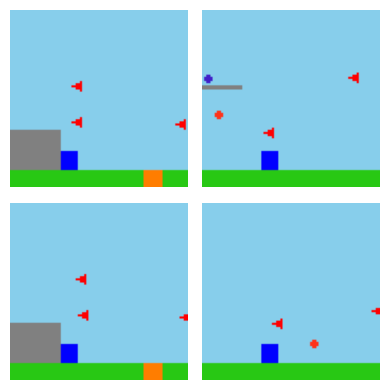

In [13]:
combine_concepts([CAVs['player dodging'], CAVs['visible bullet']], [1, 1], True)

1*visible lava


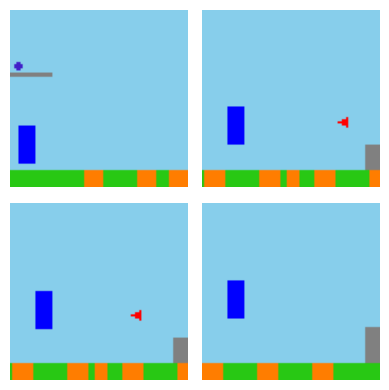

In [14]:
combine_concepts([CAVs['visible lava']], [1], True)

1*visible lava + 1*visible bullet


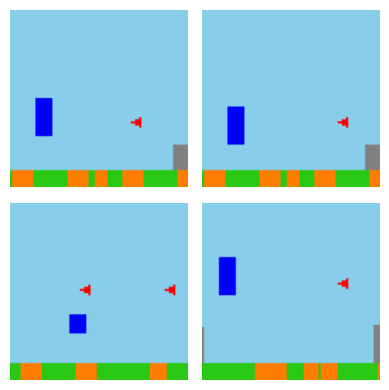

In [15]:
combine_concepts([CAVs['visible lava'], CAVs['visible bullet']], [1, 1], True)

1*player on wall - 1*visible bullet - 1*visible lava


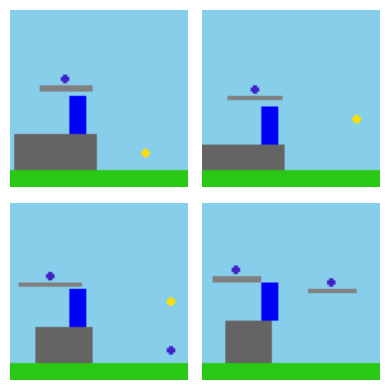

In [16]:
combine_concepts([CAVs['player on wall'], CAVs['visible bullet'], CAVs['visible lava']], [1, -1, -1], True)

1*player on wall + 1*player in air


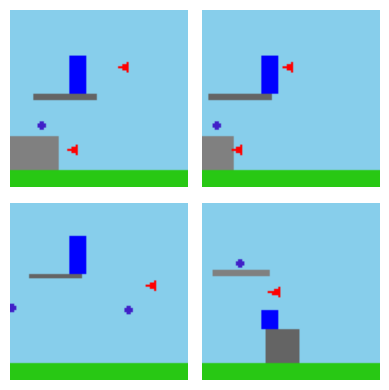

In [17]:
combine_concepts([CAVs['player on wall'], CAVs['player in air']], [1, 1], True)

1*events quantity


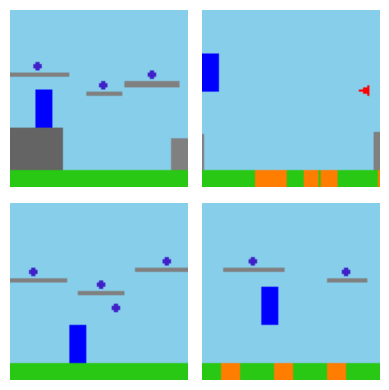

In [18]:
combine_concepts([CAVs['events quantity']], [1], True)

1*events quantity - 1*good events quantity


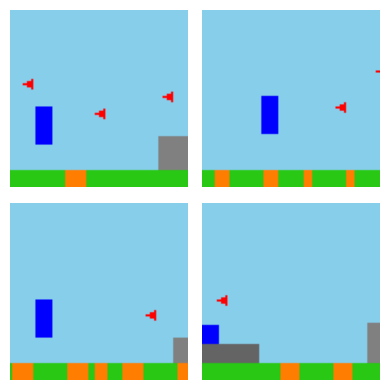

In [19]:
combine_concepts([CAVs['events quantity'], CAVs['good events quantity']], [1, -1], True)

1*visible blue coin


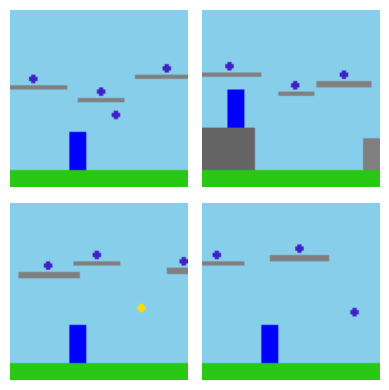

In [20]:
combine_concepts([CAVs['visible blue coin']], [1], True)

1*visible blue coin - 1*visible wall


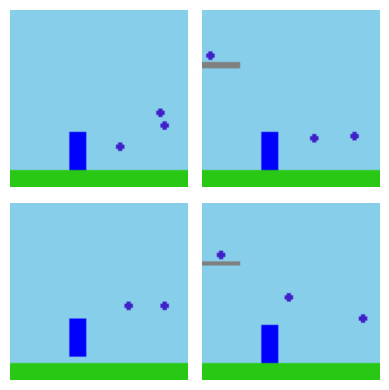

In [21]:
combine_concepts([CAVs['visible blue coin'], CAVs['visible wall']], [1, -1], True)

1*visible blue coin - 1*visible wall - 1*visible air wall


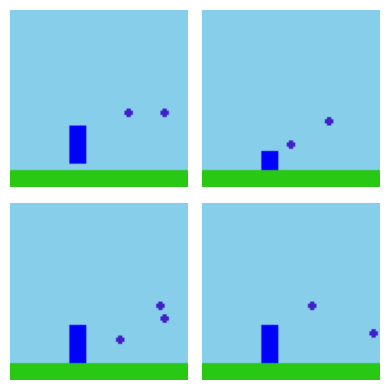

In [22]:
combine_concepts([CAVs['visible blue coin'], CAVs['visible wall'], CAVs['visible air wall']], [1, -1, -1], True)